In [1]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, glob, re, time, math, calendar

# import custom functions
sys.path.append('/')
from libraries import *
from plotters import *

In [2]:
# === Input parameters ===
input_file = 'data/ERA5.nc'
input_variables = [
    "10ws", "100ws", "100alpha", "975ws", "950ws", "975wsgrad", "950wsgrad",
    "zust", "i10fg", "t2m", "skt", "stl1", "d2m", "msl", "blh", "ishf", 
    "ie", "tcc", "lcc", "cape", "bld", "t_975", "t_950", "2mtempgrad", 
    "sktempgrad", "dewtempsprd", "975tempgrad", "950tempgrad", "sinHR", 
    "cosHR", "sinJDAY", "cosJDAY"
]
input_times_freq = 1 #ratio between the target times and input times, 12 for NOW23 data
target_variables = [0,1,2,3,4]

experiment = f'ERA5_to_profilers'
tabnet_param_file = 'best_model_params.csv'
hourly_data_method = 'Averaged_over_55th_to_5th_min'
segregated = 'segregated'
transformed = 'not_transformed'
loss_function = 'MSE_loss'
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

test_station_ids = ['PROF_WANT','PROF_BRON','PROF_REDH','PROF_JORD']
test_dates_range = ('2018-01-01T00:00:00', '2020-12-31T23:00:00')

X_test_all, Y_test_all = [], []
profiler_data_all, NOW23_data_all = [], []
for station_id in test_station_ids:
    Coeff_file = f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_id}.nc'

    if segregated == 'segregated':
        segregate_arg = True
    else:
        segregate_arg = None
    X_test, Y_test, time_coord = data_processing(input_file,Coeff_file,
                                    input_times_freq,input_variables,target_variables,test_dates_range,station_id,val_arg=None, segregate_arg=segregate_arg)
    print(X_test.shape, Y_test.shape)
    # Collect testing data for all stations
    X_test_all.append(X_test)
    Y_test_all.append(Y_test)

    # profiler and NOW23 data
    profiler_ds = xr.open_dataset(f'data/Profiler_Chebyshev_Coefficients_with_outliers/{hourly_data_method}/{station_id}.nc').Chebyshev_Coefficients
    NOW23_ds = xr.open_dataset(f'data/NOW23_Chebyshev_Coefficients/{station_id}.nc').Chebyshev_Coefficients

    profiler_data = profiler_ds.sel(time=slice(*test_dates_range,input_times_freq)).where(profiler_ds.outlier == 1, drop=True)
    profiler_data = profiler_data.sel(time=time_coord)
    NOW23_data = NOW23_ds.sel(time=time_coord)
    profiler_data_all.append(profiler_data)
    NOW23_data_all.append(NOW23_data)
    
   
if len(test_station_ids) > 1:
    X_test = np.concatenate(X_test_all, axis=0)
    Y_test = np.concatenate(Y_test_all, axis=0)
    profiler_data = xr.concat(profiler_data_all, dim='time')
    NOW23_data = xr.concat(NOW23_data_all, dim='time')
else:
    X_test = X_test_all[0]
    Y_test = Y_test_all[0]
    profiler_data = profiler_data_all[0]
    NOW23_data = NOW23_data_all[0]

print(X_test.shape, Y_test.shape, profiler_data.shape, NOW23_data.shape)

Segregated times: 18446
Intersected times: 18043
(18043, 32) (18043, 5)
Segregated times: 16941
Intersected times: 16569
(16569, 32) (16569, 5)
Segregated times: 13816
Intersected times: 13587
(13587, 32) (13587, 5)
Segregated times: 15541
Intersected times: 15216
(15216, 32) (15216, 5)
(63415, 32) (63415, 5) (63415, 5) (63415, 5)


In [35]:
from sklearn.cluster import KMeans
data = profiler_data.values  # Convert to 2D array: [time, coeffs]

# Apply k-means clustering
n_clusters = 36
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)  # Specify n_clusters as needed
labels = kmeans.labels_

# Add the labels as a new coordinate in the profiler_data
profiler_data_with_clustering = profiler_data.assign_coords(cluster=('time', labels))

Cluster 0: (1488, 5)
Cluster 1: (3709, 5)
Cluster 2: (1720, 5)
Cluster 3: (1172, 5)
Cluster 4: (1902, 5)
Cluster 5: (2624, 5)
Cluster 6: (2427, 5)
Cluster 7: (2094, 5)
Cluster 8: (1484, 5)
Cluster 9: (2955, 5)
Cluster 10: (3851, 5)
Cluster 11: (509, 5)
Cluster 12: (374, 5)
Cluster 13: (1464, 5)
Cluster 14: (2643, 5)
Cluster 15: (3023, 5)
Cluster 16: (1689, 5)
Cluster 17: (2081, 5)
Cluster 18: (1233, 5)
Cluster 19: (568, 5)
Cluster 20: (1860, 5)
Cluster 21: (2052, 5)
Cluster 22: (742, 5)
Cluster 23: (678, 5)
Cluster 24: (1153, 5)
Cluster 25: (1896, 5)
Cluster 26: (2265, 5)
Cluster 27: (187, 5)
Cluster 28: (1643, 5)
Cluster 29: (3767, 5)
Cluster 30: (1921, 5)
Cluster 31: (1674, 5)
Cluster 32: (844, 5)
Cluster 33: (862, 5)
Cluster 34: (871, 5)
Cluster 35: (1990, 5)


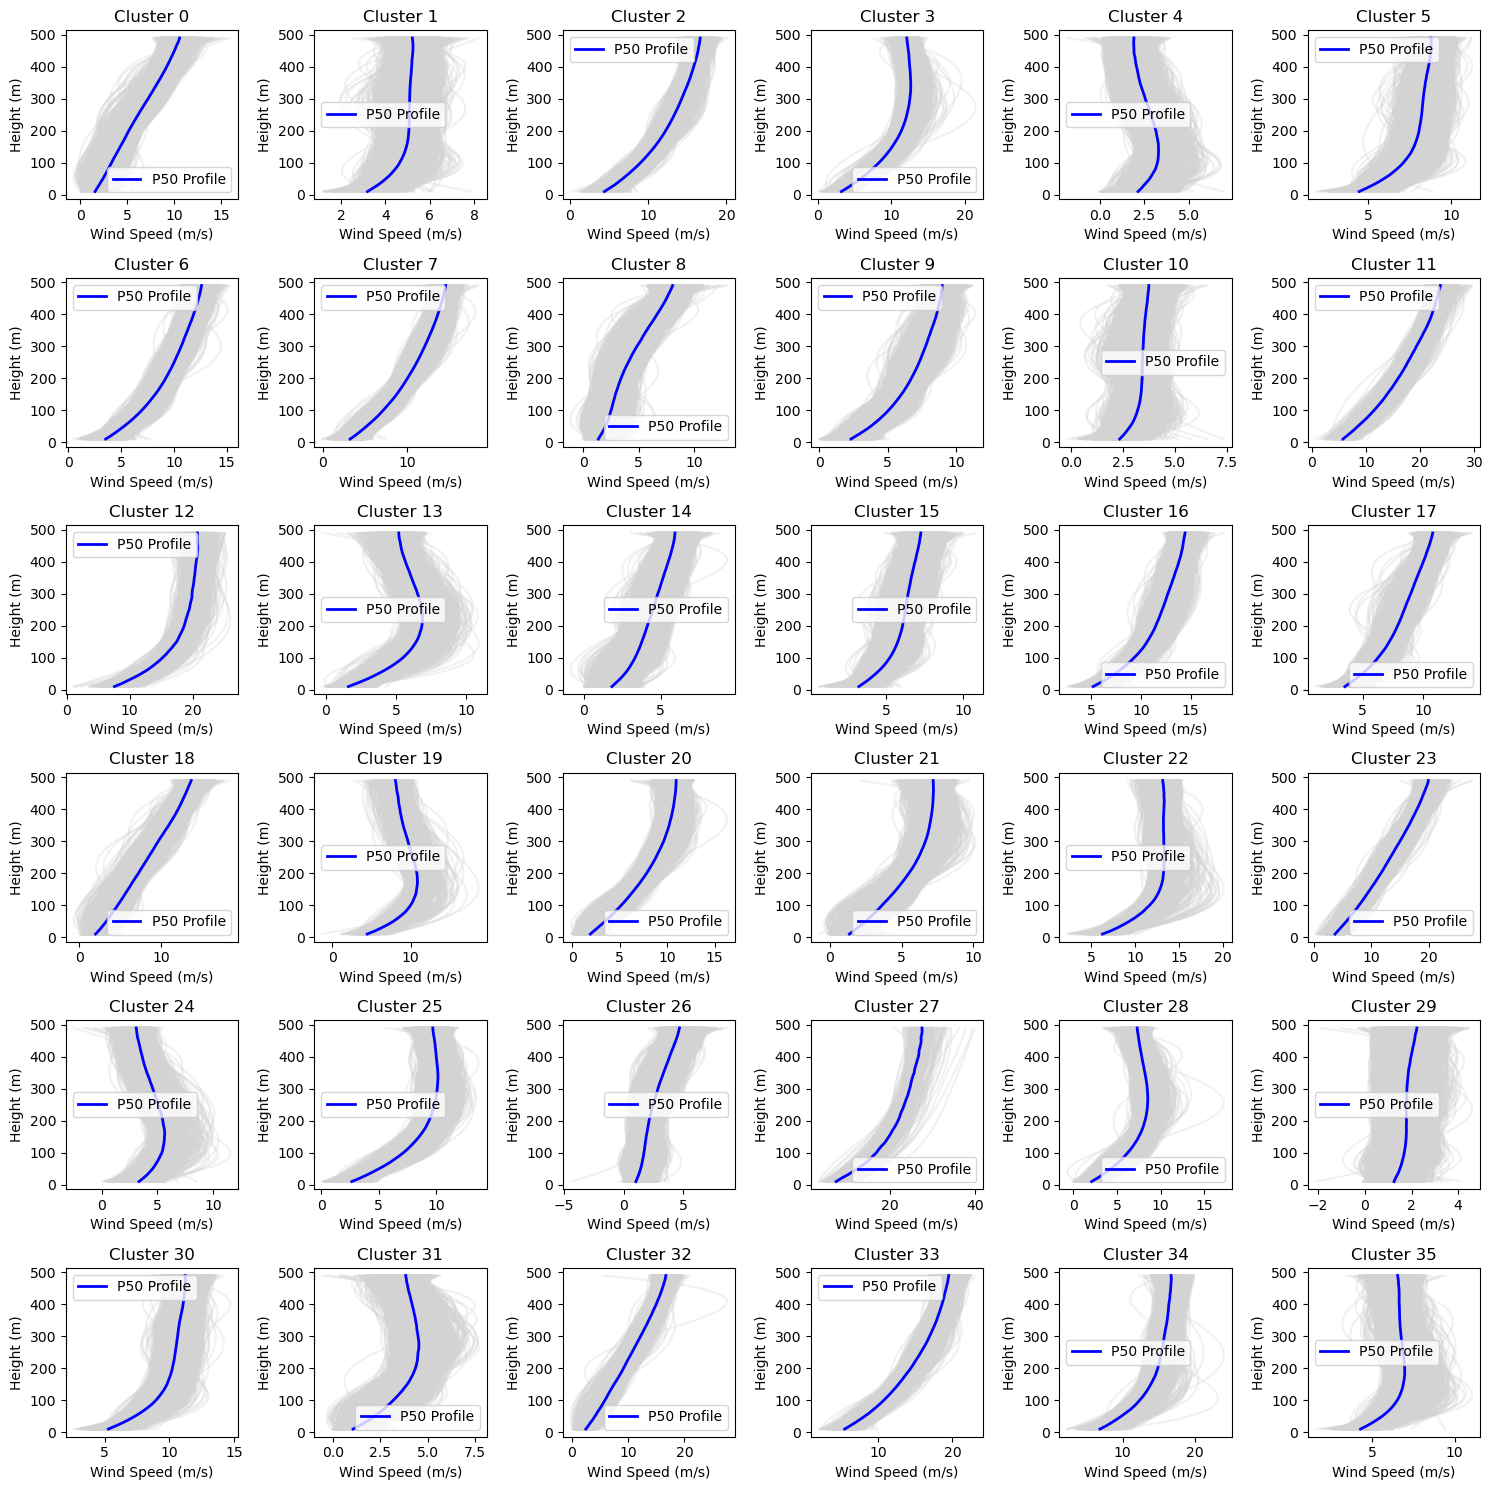

In [36]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(6,6, figsize=(15, 15))
Z = np.arange(10, 500, 10)

for i in range(n_clusters):
    profile = profiler_data_with_clustering.where(profiler_data_with_clustering.cluster == i, drop=True)
    print(f'Cluster {i}:', profile.shape)

    # Create wind profile for the current cluster
    wpz = WindProfile(Z, profile.values.T, poly_order=poly_order, CPtype=CPtype, ref_H=ref_H)
    
    # Calculate the P50 (median) across the profiles for each altitude
    p50_profile = np.median(wpz, axis=1)

    # Select the current subplot
    ax = axes[i // 6, i % 6]

    # Plot each wind profile in the ensemble in light color
    for prof in wpz.T:
        ax.plot(prof, Z, color='lightgray', alpha=0.3)

    # Plot the P50 profile in a distinct color
    ax.plot(p50_profile, Z, color='blue', linewidth=2, label='P50 Profile')

    # Set labels and title for each subplot
    ax.set_xlabel('Wind Speed (m/s)')
    ax.set_ylabel('Height (m)')
    ax.set_title(f'Cluster {i}')
    ax.legend()

# Adjust layout for better visualization
plt.tight_layout()
plt.show()
